In [5]:
import numpy as np
import cv2
import math
import random
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda
from keras.layers import MaxPooling2D, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn.utils

2021-11-25 03:31:35.839685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 03:31:35.839709: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
img_width = 100
img_height = 100

In [14]:
def process_img(img):
    img = img[-160:-20] # Cut out the useless features
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (img_width, img_height))
    return img


In [20]:
def load_data():
    X = []
    Y = []
    
    file = open("./data/angles_raw.txt") 
    lines = file.readlines()
    
    i = 200
    while i < 120000:
        file = open("./data/angles_raw.txt") 
        line = str(lines[i])
        img = cv2.imread("data/img/" + line.split()[0])
        processed_img = process_img(img)
        X.append(processed_img)
        Y.append(float(line.split()[1]) * math.pi / 180)
        i += 10
    print("Finished loading data!")

    return np.array(X).astype('float32'), np.array(Y).astype('float32')

In [21]:
(X, Y) = load_data()

Finished loading data!


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0,
                                                        test_size=0.2, shuffle=False)

In [23]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9584, 100, 100)
(9584,)
(2396, 100, 100)
(2396,)


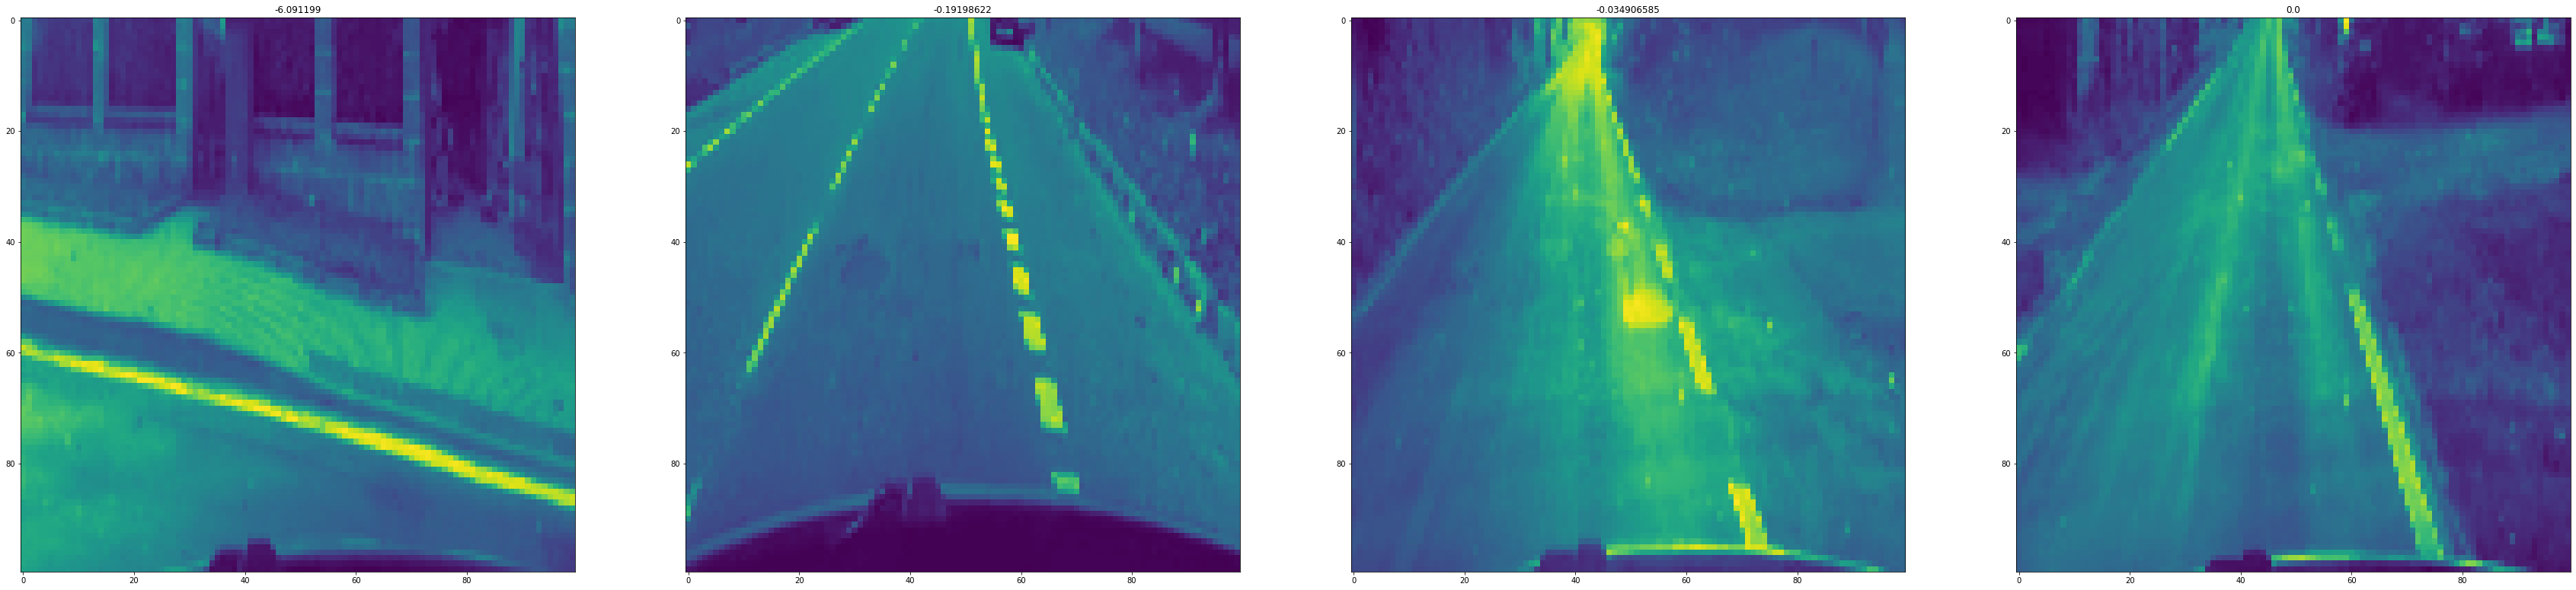

In [24]:
fig, axarr = plt.subplots(1, 4, figsize=(60, 60))

axarr[0].imshow(X[0])
axarr[0].title.set_text(Y_train[0])

axarr[1].imshow(X_test[0])
axarr[1].title.set_text(Y_train[10])

axarr[2].imshow(X_train[20])
axarr[2].title.set_text(Y_train[20])

axarr[3].imshow(X_train[30])
axarr[3].title.set_text(Y_train[30])

In [25]:
X_train_flattened = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_test_flattened = X_test.reshape(X_test.shape[0], img_width, img_height)

In [26]:
print(X_train_flattened.shape)
print(Y_train.shape)
print(X_test_flattened.shape)
print(Y_test.shape)

(9584, 100, 100, 1)
(9584,)
(2396, 100, 100)
(2396,)


In [27]:
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoints/checkpoints.ckpt",
        save_weights_only=True,
        verbose=1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: x / 127.5 - 1,
                           input_shape=(img_width, img_height, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss="mse")

2021-11-25 03:37:42.686265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 03:37:42.686710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 03:37:42.686830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-25 03:37:42.686928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-25 03:37:42.791280: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [28]:
history = model.fit(
        X_train_flattened, Y_train,
        validation_data=(X_test_flattened, Y_test),
        epochs=20,
        batch_size=32,
        verbose=1)

Epoch 1/20
300/300 [==============================] - 53s 173ms/step - loss: 0.8100 - val_loss: 0.6963
Epoch 2/20
300/300 [==============================] - 53s 177ms/step - loss: 0.7778 - val_loss: 0.6719
Epoch 3/20
300/300 [==============================] - 52s 174ms/step - loss: 0.6527 - val_loss: 0.6318
Epoch 4/20
300/300 [==============================] - 53s 176ms/step - loss: 0.5718 - val_loss: 0.6134
Epoch 5/20
300/300 [==============================] - 52s 173ms/step - loss: 0.5005 - val_loss: 0.6597
Epoch 6/20
300/300 [==============================] - 52s 174ms/step - loss: 0.4866 - val_loss: 0.6755
Epoch 7/20
300/300 [==============================] - 51s 172ms/step - loss: 0.4563 - val_loss: 0.6353
Epoch 8/20
300/300 [==============================] - 55s 183ms/step - loss: 0.3919 - val_loss: 0.5922
Epoch 9/20
300/300 [==============================] - 61s 204ms/step - loss: 0.3455 - val_loss: 0.5789
Epoch 10/20
300/300 [==============================] - 59s 197ms/step - l

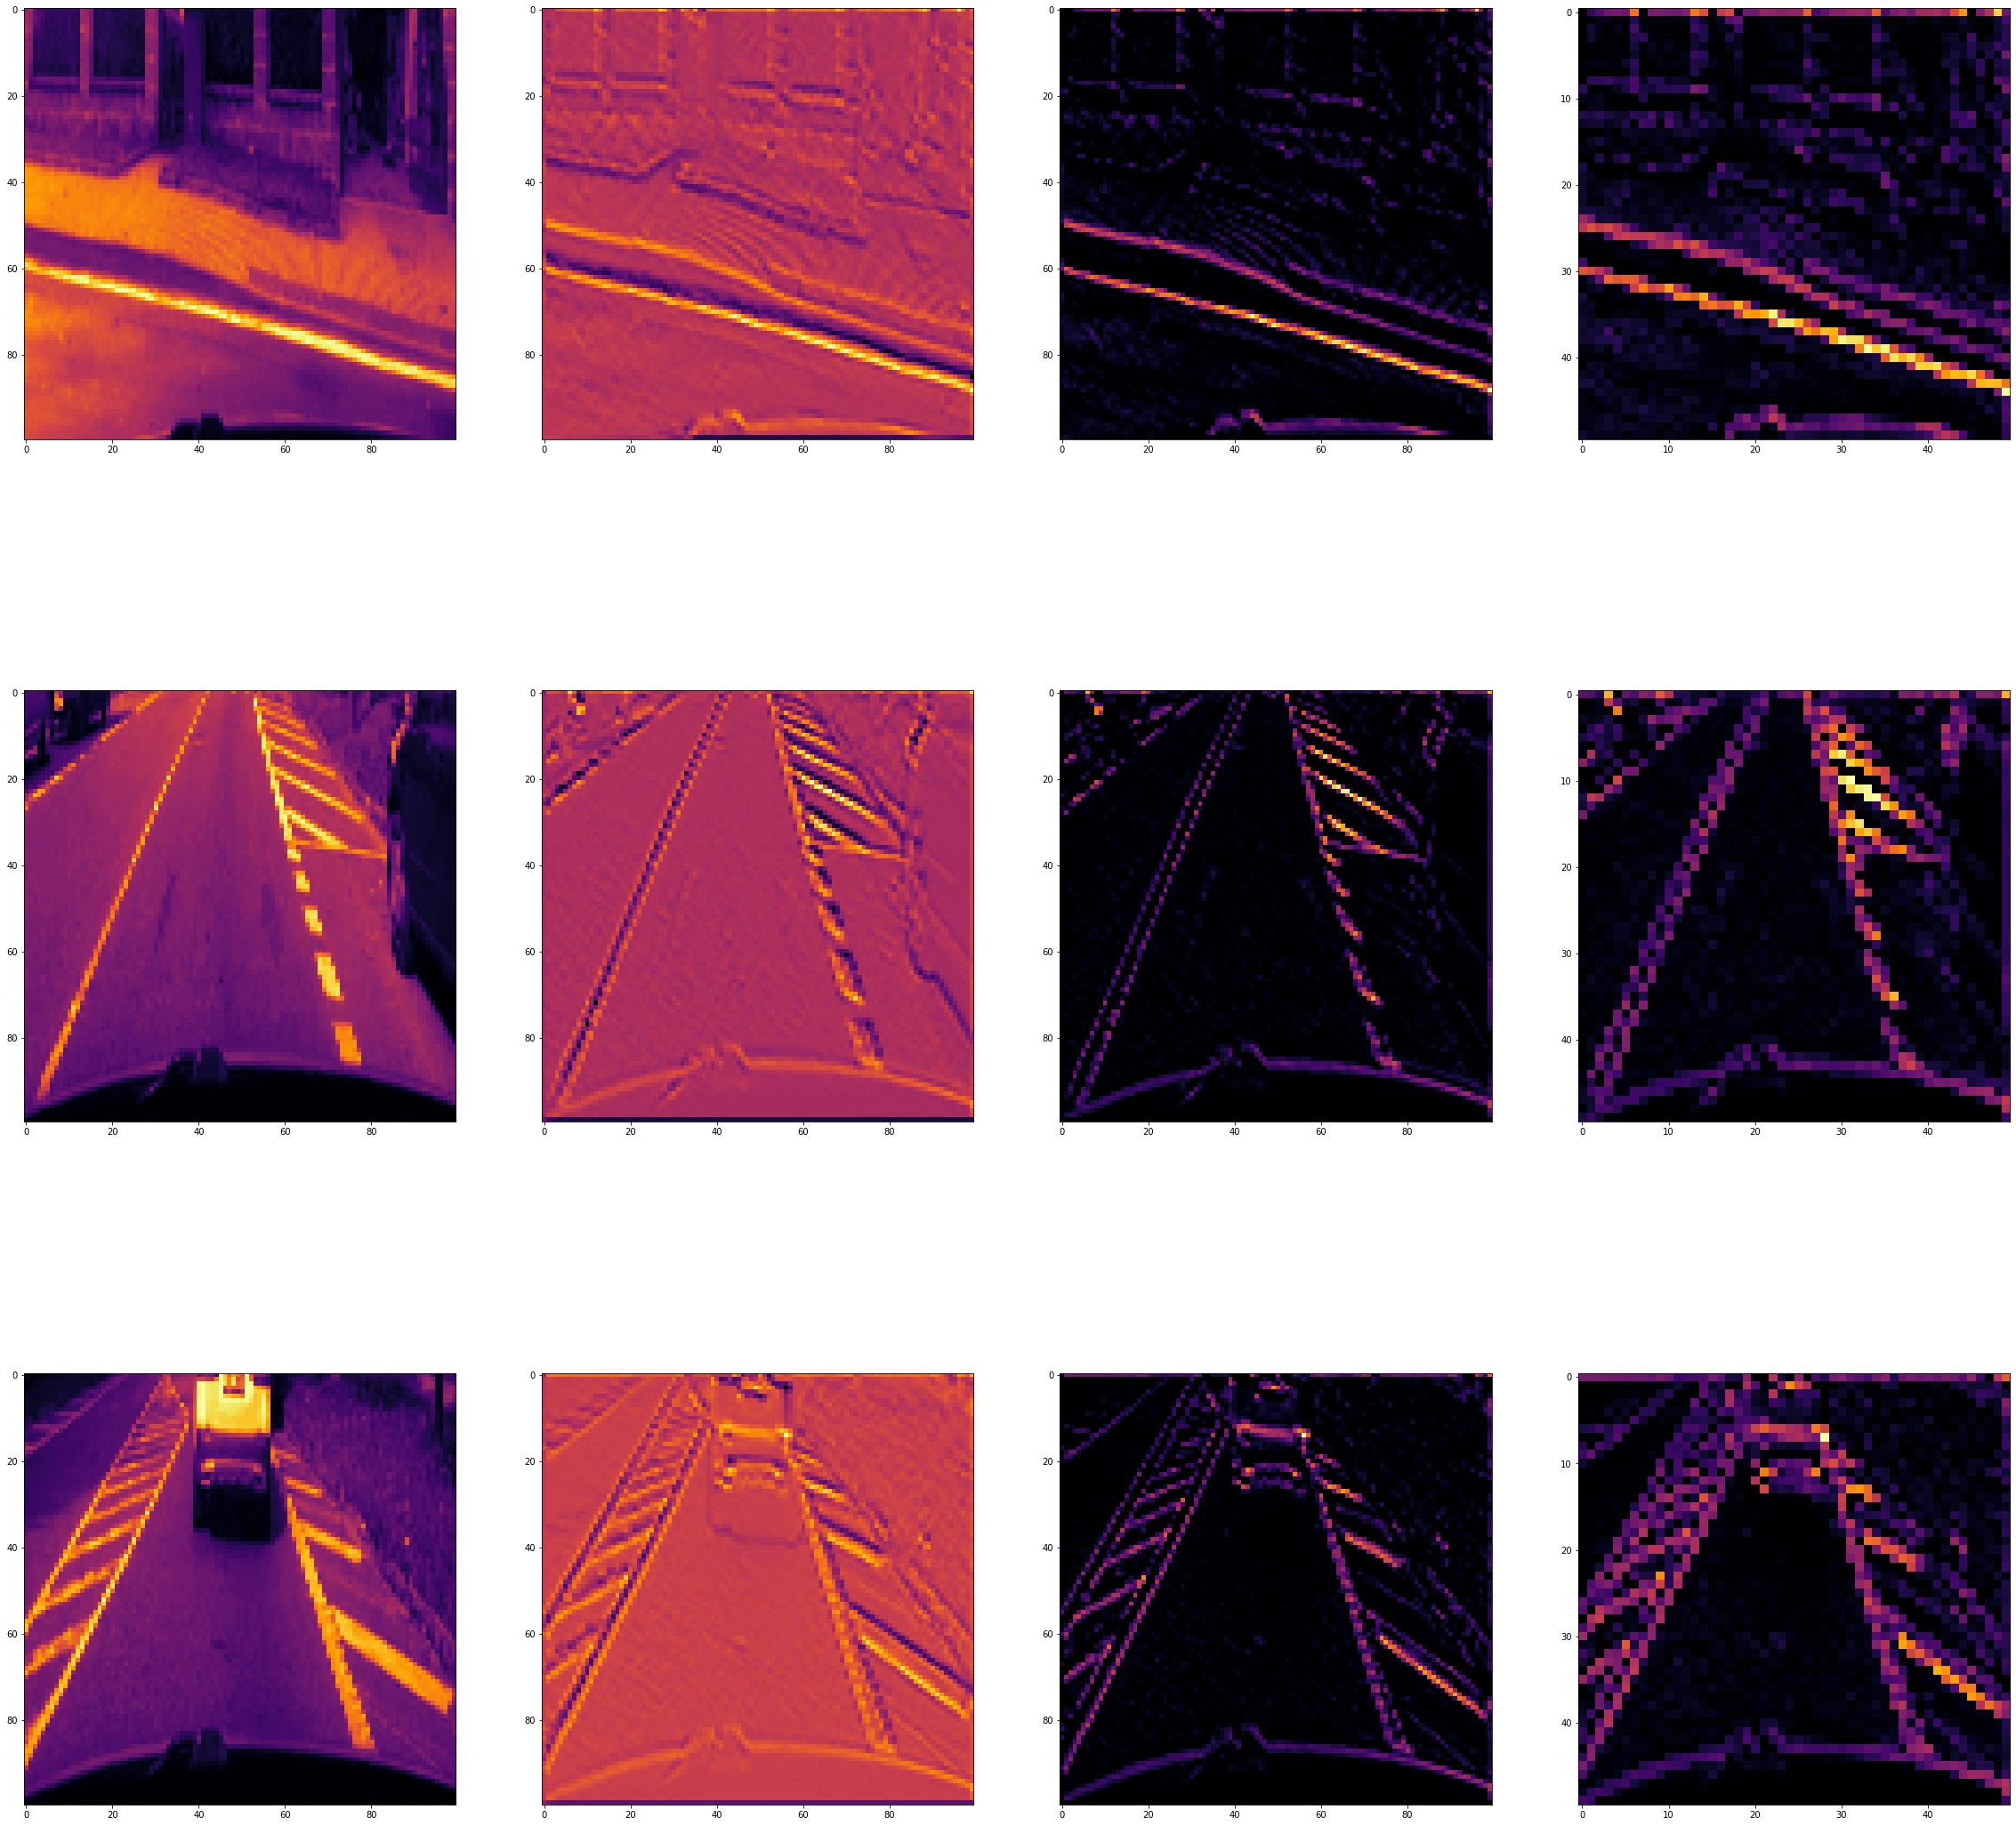

In [29]:
f, axarr = plt.subplots(3, 4, figsize=(40, 40))
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 0
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for i in range(0, 4):
  f1 = activation_model.predict(X_train[FIRST_IMAGE].reshape(1, img_width, img_height, 1))[i]
  axarr[0, i].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0, i].grid(False)
  f2 = activation_model.predict(X_test[SECOND_IMAGE].reshape(1, img_width, img_height, 1))[i]
  axarr[1, i].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1, i].grid(False)
  f3 = activation_model.predict(X_test[THIRD_IMAGE].reshape(1, img_width, img_height, 1))[i]
  axarr[2, i].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2, i].grid(False)

In [31]:
model.save("checkpoints/model.h5")
results = model.evaluate(X_test, Y_test)
Y_predict = model.predict(X_test)

75/75 [==============================] - 3s 36ms/step - loss: 0.5631


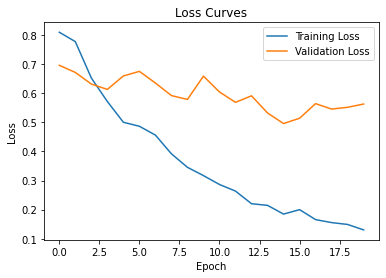

In [32]:
plt.figure()
plt.subplot()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
            'Validation Loss'])
plt.title('Loss Curves')
plt.show()
